In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

%config Completer.use_jedi = False
%matplotlib inline

In [2]:
df_sales = pd.read_csv('../data/1c_ms_dollar_sales.csv')
df_currency = pd.read_csv('../data/exchange_rates.csv')
df_products = pd.read_csv('../data/ms_products_clean.csv')

In [3]:
for old_column_name in df_sales.columns:
    new_column_name = old_column_name.lower().replace(' ', '_')
    df_sales = df_sales.rename(columns={old_column_name: new_column_name})
    
for old_column_name in df_currency.columns:
    new_column_name = old_column_name.lower().replace(' ', '_')
    df_currency = df_currency.rename(columns={old_column_name: new_column_name})

In [4]:
df_sales['сумма_продаж'] = df_sales['кол-во'] * df_sales['цена']

In [5]:
df_sales['время'] = pd.to_datetime(df_sales['время'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df_sales['дата'] = df_sales['время'].dt.date
df_sales['год_месяц'] = df_sales['время'].dt.year.astype('str') + \
                  df_sales['время'].dt.month.apply(lambda x: '0'+str(x) if len(str(x)) < 2 else str(x))
df_sales['дата'] = df_sales['дата'].astype('str')

In [7]:
df_sales_full = df_sales.merge(df_currency, left_on='дата', right_on='date').drop('date', axis=1)

In [8]:
df_sales_full['продажи_грн'] = (df_sales_full['сумма_продаж'] * df_sales_full['курс_доллара']).astype('int')

In [9]:
df_sales_customers = df_sales_full.query('код_клиента != "KL339"')

<AxesSubplot:>

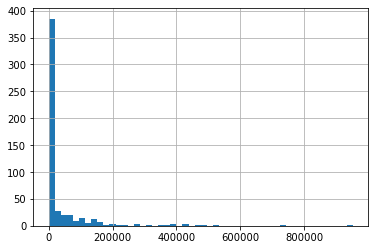

In [10]:
df_sales_customers.groupby('код_клиента', as_index=False) \
    .agg({'продажи_грн': 'sum'})['продажи_грн'].hist(bins=50)

In [11]:
df_sales_customers.groupby(['год_месяц'], as_index=False) \
    .agg({'код_клиента': 'nunique'})

год_месяц  код_клиента
0     201601           34
1     201602           34
2     201603           32
3     201604           85
4     201605           70
..       ...          ...
64    202105           54
65    202106           54
66    202107           79
67    202108           55
68    202109           47

[69 rows x 2 columns]

In [12]:
from efficient_apriori import apriori

ModuleNotFoundError: No module named 'efficient_apriori'

In [ ]:
def build_group(group_1, group_2):
    if str(group_2) == 'nan':
        return str(group_1)
    else:
        return str(group_2)
    
v = np.vectorize(build_group)

df_products['group'] = v(df_products['group_1'], df_products['group_2'])

In [13]:
df_for_apriori = df_sales_customers.merge(df_products[['Код', 'group']], left_on='код_товара', right_on='Код')

KeyError: "['group'] not in index"

In [14]:
srs_groups = df_for_apriori.groupby('код_заказа', as_index=False) \
    .agg({'group': 'unique'})['group']
srs_groups

NameError: name 'df_for_apriori' is not defined

In [15]:
def return_apriori_products(rule):
    rule_text = str(rule)
    rule_list = rule_text.replace('} -> {', '/').replace('} (', '/').replace('{', '').split('/')
    rule_list = rule_list[:2]
    return rule_list

transactions = list(map(tuple, srs_groups))
itemsets, rules = apriori(transactions, min_support=0.01, min_confidence=0.3)

for rule in rules:
    first_product = return_apriori_products(rule)[0]
    second_product = return_apriori_products(rule)[1]
    confidence = round(rule.confidence * 100, 1)
    support = round(rule.support * 100, 2)
    lift = round(rule.lift, 1)
    
    print(f'При покупке "{first_product}" в {confidence}% случаев у нас также берут "{second_product}".\
    При чем вероятность взять "{second_product}" в {lift} раз выше когда берут "{first_product}"\
    по сравнению с обычными продажами. Всего такие случаи составляют {support}% от всех чеков\n')

NameError: name 'srs_groups' is not defined

In [16]:
from fbprophet import Prophet

In [17]:
df_sales_full.dtypes

код_товара              object
код_клиента             object
время           datetime64[ns]
кол-во                 float64
себест.                float64
цена                   float64
код_заказа              object
сумма_продаж           float64
дата                    object
год_месяц               object
курс_доллара           float64
продажи_грн              int32
dtype: object

In [18]:
df_sales_customers['дата'] = pd.to_datetime(df_sales_customers['дата'])

<ipython-input-18-1084a0d57121>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales_customers['дата'] = pd.to_datetime(df_sales_customers['дата'])


In [19]:
import holidays
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2016, 2017, 2018, 2019, 2020, 2021))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head()

ds    holiday
0 2016-01-01  Новый год
1 2016-01-02  Новый год
2 2016-01-03  Новый год
3 2016-01-04  Новый год
4 2016-01-05  Новый год

In [20]:
rolling_period = 15

grp_daily_sails = df_sales_customers.groupby('дата', as_index=False) \
    .agg({'продажи_грн': 'sum'})
# df_date_table = pd.DataFrame({'дата': pd.date_range(grp_daily_sails['дата'].min(), grp_daily_sails['дата'].max())})
# grp_daily_sails = df_date_table.merge(grp_daily_sails, on='дата', how='left')
# grp_daily_sails = grp_daily_sails.fillna(0)
grp_daily_sails['sales_rolling'] = grp_daily_sails['продажи_грн'].rolling(rolling_period).mean()
grp_daily_sails.head()

дата  продажи_грн  sales_rolling
0 2016-01-04         2041            NaN
1 2016-01-05         6350            NaN
2 2016-01-06         1951            NaN
3 2016-01-11         8695            NaN
4 2016-01-12        15550            NaN

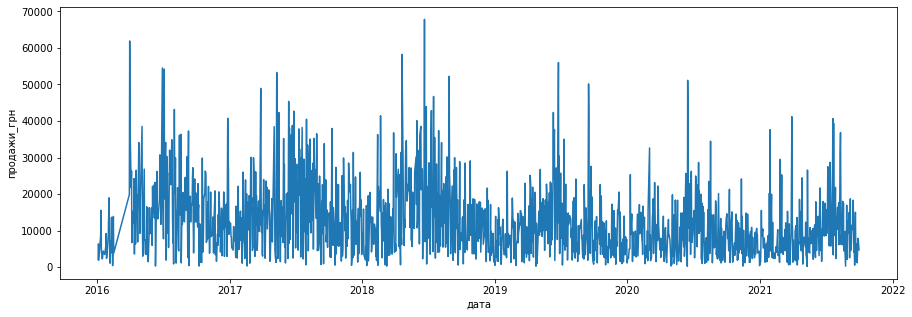

In [21]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=grp_daily_sails, x='дата', y='продажи_грн');

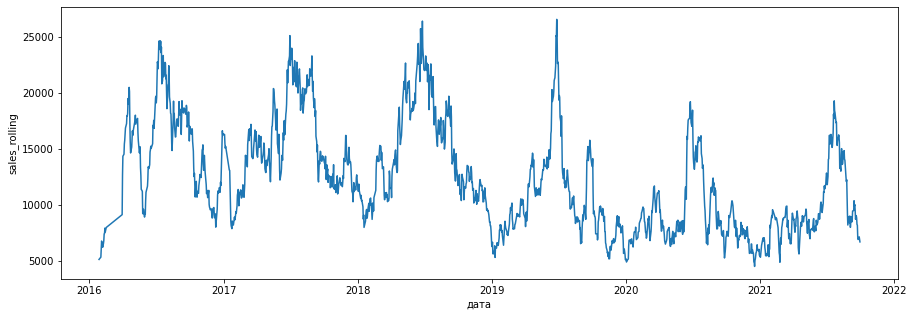

In [22]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=grp_daily_sails, x='дата', y='sales_rolling');

In [23]:
grp_daily_sales_for_prophet = grp_daily_sails[['дата', 'sales_rolling']].rename(columns={'дата': 'ds',
                                                                                       'sales_rolling': 'y'})

grp_daily_sales_for_prophet.head()

ds   y
0 2016-01-04 NaN
1 2016-01-05 NaN
2 2016-01-06 NaN
3 2016-01-11 NaN
4 2016-01-12 NaN

In [24]:
# Период, который нам надо отрезать и предсказать (проверка модели)
predictions = 90

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = grp_daily_sales_for_prophet[:-predictions]
train_df.tail()

ds            y
1501 2021-06-08  8712.733333
1502 2021-06-09  9211.333333
1503 2021-06-11  9176.800000
1504 2021-06-12  8717.533333
1505 2021-06-14  9543.933333

In [25]:
# Настраиваем prophet - говорим ему учитывать праздники и сезонности
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_df.query('ds > "2015-01-01"'))

In [26]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

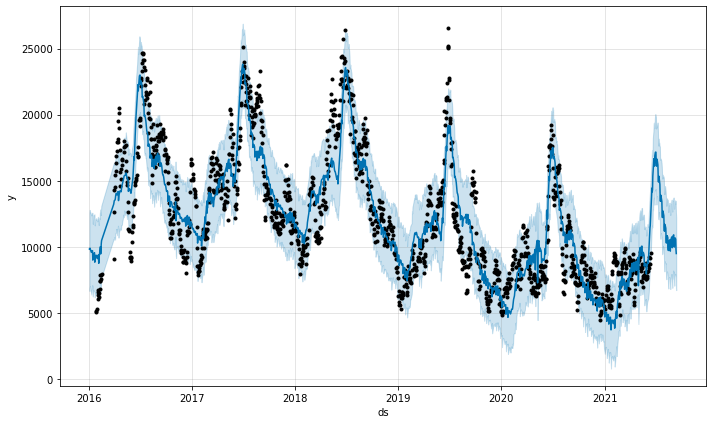

In [27]:
m.plot(forecast);

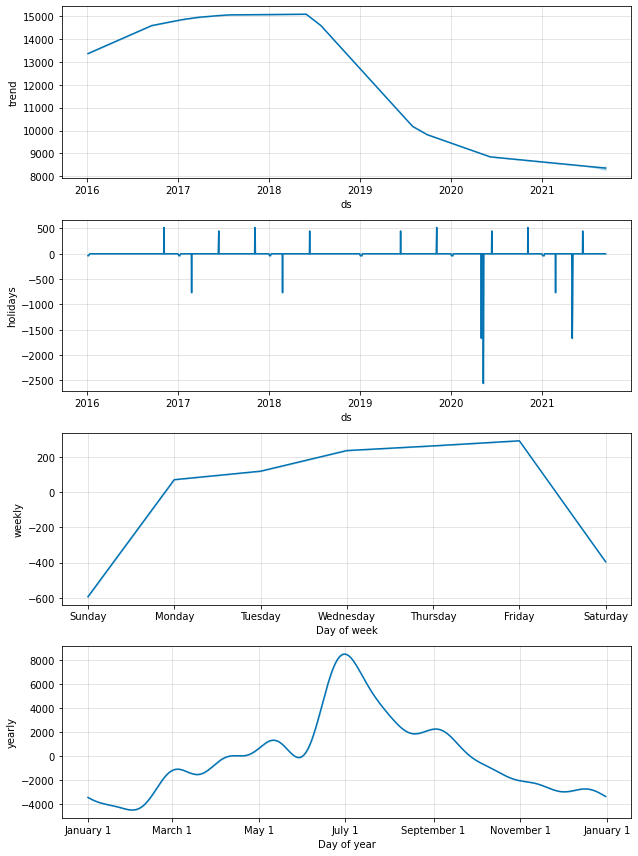

In [28]:
m.plot_components(forecast);

In [29]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(grp_daily_sales_for_prophet.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  24.80402025219801 %
MAE (средняя абсолютная ошибка) –  3171.7302506318492


In [30]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 365

final_train_df = grp_daily_sales_for_prophet
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [31]:
final_forecast.head()

ds         trend   yhat_lower    yhat_upper   trend_lower  \
0 2016-01-04  13577.835435  7214.616791  13128.125429  13577.835435   
1 2016-01-05  13581.521406  7101.263808  12750.571888  13581.521406   
2 2016-01-06  13585.207377  7156.053820  12792.806799  13585.207377   
3 2016-01-11  13603.637232  6991.652781  12833.294833  13603.637232   
4 2016-01-12  13607.323203  7167.082267  12821.885634  13607.323203   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  13577.835435    -3502.770847          -3502.770847          -3502.770847   
1  13581.521406    -3511.266207          -3511.266207          -3511.266207   
2  13585.207377    -3435.783032          -3435.783032          -3435.783032   
3  13603.637232    -3748.625551          -3748.625551          -3748.625551   
4  13607.323203    -3736.389349          -3736.389349          -3736.389349   

    holidays  ...  Православное Рождество  Православное Рождество_lower  \
0 -40.465843  ...                     0.0                           0.0   
1 -40.465843  ...                     0.0                           0.0   
2 -40.465843  ...                     0.0                           0.0   
3   0.000000  ...                     0.0                           0.0   
4   0.000000  ...                     0.0                           0.0   

   Православное Рождество_upper  Праздник Весны и Труда  \
0                           0.0                     0.0   
1                           0.0                     0.0   
2                           0.0                     0.0   
3                           0.0                     0.0   
4                           0.0                     0.0   

   Праздник Весны и Труда_lower  Праздник Весны и Труда_upper  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  10075.064589  
1                         0.0  10070.255199  
2                         0.0  10149.424346  
3                         0.0   9855.011682  
4                         0.0   9870.933855  

[5 rows x 46 columns]

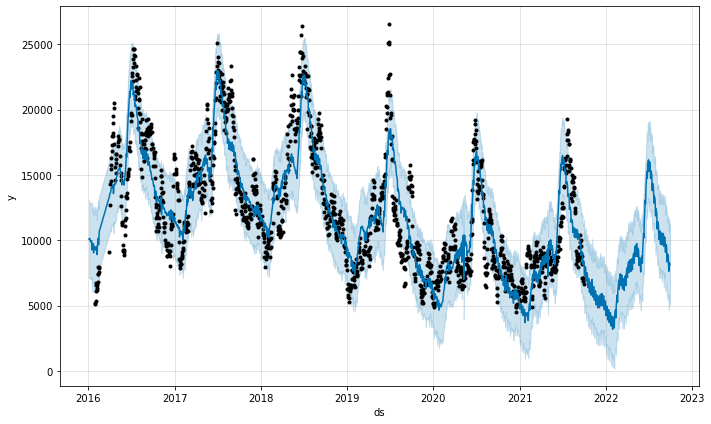

In [32]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast);

In [33]:
df_sales_full_customers = df_sales_full.query('код_клиента != "KL339"')

In [34]:
df_sales_full_customers = df_sales_full_customers.dropna()

In [35]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df_sales_full_customers.to_sql('sales', engine, index=False, if_exists='replace')

<AxesSubplot:>

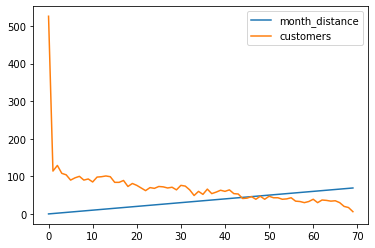

In [36]:
query = """
SELECT
    month_distance
    , count(DISTINCT код_клиента) as customers
FROM (
    SELECT
        l.код_клиента as код_клиента
        , date(l.дата) as дата
        , date(r.birth_date) as birth_date
        , CAST(JulianDay(l.дата) - JulianDay(r.birth_date) as Integer) / 30 as month_distance
    FROM sales l
    LEFT JOIN (
        SELECT 
            код_клиента
            , min(date(дата)) as birth_date
        FROM sales
        GROUP BY код_клиента) r ON l.код_клиента = r.код_клиента)
GROUP BY month_distance
ORDER BY month_distance
"""

pd.read_sql(query, engine).plot()

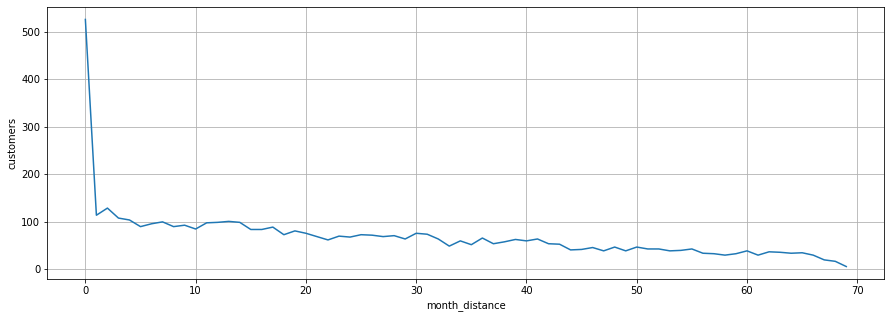

In [37]:
query = """
SELECT
    month_distance
    , count(DISTINCT код_клиента) as customers
FROM (
    SELECT
        *
        , CAST(JulianDay(дата) - JulianDay(birth_date) as Integer) / 30 as month_distance
    FROM (
        SELECT
            код_клиента
            , Date(дата) as дата
            , min(Date(дата)) OVER (PARTITION BY код_клиента) as birth_date
        FROM sales))
GROUP BY month_distance
"""
plt.figure(figsize=(15, 5))
plt.grid()
sns.lineplot(data=pd.read_sql(query, engine), x='month_distance', y='customers');

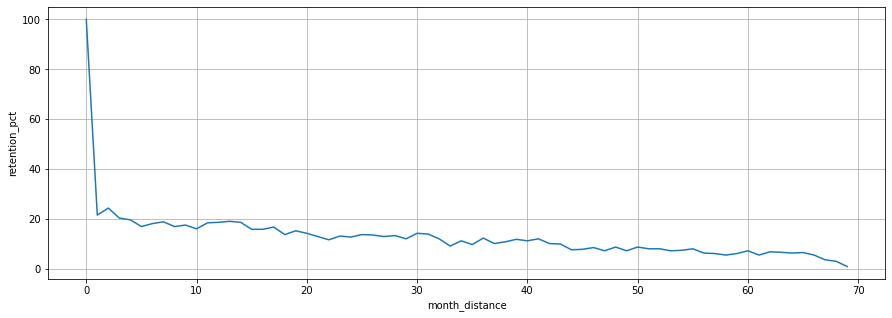

In [38]:
query = """
SELECT
    month_distance
    , count(DISTINCT код_клиента) as customers
    , ROUND(count(DISTINCT код_клиента) * 100.0 
                    / max(count(DISTINCT код_клиента)) OVER (), 1) as retention_pct
FROM (
    SELECT
        *
        , CAST(JulianDay(дата) - JulianDay(birth_date) as Integer) / 30 as month_distance
    FROM (
        SELECT
            код_клиента
            , Date(дата) as дата
            , min(Date(дата)) OVER (PARTITION BY код_клиента) as birth_date
        FROM sales))
GROUP BY month_distance
"""
plt.figure(figsize=(15, 5))
plt.grid()
sns.lineplot(data=pd.read_sql(query, engine), x='month_distance', y='retention_pct');

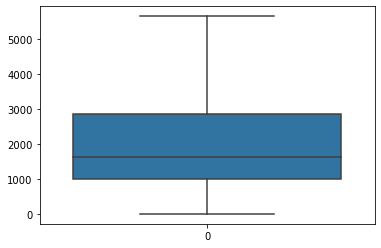

In [39]:
sns.boxplot(data=df_sales_full_customers.groupby('код_заказа', as_index=False) \
    .agg({'продажи_грн': 'sum'})['продажи_грн'], showfliers=False);

In [40]:
customer_avg_check_quantile = 0.05

quant = df_sales_full_customers.groupby('код_заказа', as_index=False) \
        .agg({'продажи_грн': 'sum'})['продажи_грн'].quantile(customer_avg_check_quantile)

ar_bad_customers = df_sales_full_customers.groupby(['код_клиента', 'код_заказа'], as_index=False) \
                                    .agg({'продажи_грн': 'sum'}) \
                                    .rename(columns={'продажи_грн': 'total_check'}) \
                                    .groupby('код_клиента', as_index=False) \
                                    .agg({'код_заказа': 'count', 'total_check': 'mean'}) \
                                    .rename(columns={'total_check': 'avg_check', 'код_заказа': 'sales_count'}) \
                                    .query('avg_check < @quant and sales_count <= 1')['код_клиента'].values
ar_bad_customers = str(ar_bad_customers)
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789' "
new_string = ''
for letter in ar_bad_customers:
    if letter in alphabet:
        new_string += letter
new_string = '(' + new_string + ')'
ar_bad_customers = new_string.replace(' ', ',')
ar_bad_customers

"('KL012','KL016','KL025','KL030','KL032','KL065','KL079','KL085','KL093','KL095','KL101','KL125','KL126','KL132','KL136','KL146','KL163','KL164','KL168','KL184','KL191','KL193','KL196','KL201','KL204','KL206','KL211','KL222','KL237','KL257','KL262','KL269','KL281','KL283','KL296','KL299','KL304','KL313','KL324','KL327','KL331','KL356','KL357','KL371','KL382','KL388','KL391','KL402','KL407','KL416','KL417','KL427','KL432','KL439','KL441','KL443','KL444','KL447','KL451','KL452','KL455','KL489','KL491','KL500','KL505','KL506','KL542','KL558','KL574','KL580','KL606','KL616','KL637','KL639','KL641','KL643')"

In [41]:
query = f"""
SELECT
    *
    , ROUND(customers_in_period * 100.0 
        / max(customers_in_period) OVER (PARTITION BY cohort), 0) as cohort_pct
FROM (
    SELECT
        birth_date as cohort
        , month_from_1st_purchase as period
        , count(DISTINCT customer_id) as customers_in_period
    FROM (
        SELECT
            customer_id
            , birth_date
            , CAST(julianday(date) - julianday(birth_date) as INTEGER) / 31 as month_from_1st_purchase
        FROM (
            SELECT 
                код_клиента as customer_id
                , Date(дата) as date
                , Date(
                    min(дата) OVER (PARTITION BY код_клиента), 'start of month') as birth_date
            FROM sales
            WHERE код_клиента NOT IN {ar_bad_customers}))
    GROUP BY birth_date, month_from_1st_purchase)
"""
grp_cohorts = pd.read_sql(query, engine)
grp_cohorts['cohort_pct'] = grp_cohorts['cohort_pct'].astype('int')
grp_cohorts.head()

cohort  period  customers_in_period  cohort_pct
0  2016-01-01       0                   33         100
1  2016-01-01       1                   13          39
2  2016-01-01       2                   17          52
3  2016-01-01       3                   22          67
4  2016-01-01       4                   19          58

In [42]:
# ABC customer analysis
query = """
SELECT
    *
    , CASE WHEN cumulative_sales_pct <= 80 THEN "A" 
           WHEN cumulative_sales_pct > 80  AND cumulative_sales_pct <= 95 THEN "B"
           ELSE "C" END as abc_group
FROM (
SELECT
    *
    , sum(total_sales) OVER(ORDER BY total_sales DESC) * 100.0 / 
        sum(total_sales) OVER() as cumulative_sales_pct
FROM (
    SELECT
        код_клиента as customer_id
        , sum(продажи_грн) as total_sales
    FROM sales
    GROUP BY customer_id
    ORDER BY total_sales DESC))
"""
pd.read_sql(query, engine)

customer_id  total_sales  cumulative_sales_pct abc_group
0         KL367       951566              4.825192         A
1         KL075       742207              8.588769         A
2         KL317       528375             11.268048         A
3         KL277       481312             13.708681         A
4         KL038       472398             16.104112         A
..          ...          ...                   ...       ...
521       KL191           48             99.999336         C
522       KL427           47             99.999574         C
523       KL283           35             99.999752         C
524       KL331           29             99.999899         C
525       KL313           20            100.000000         C

[526 rows x 4 columns]

In [43]:
plt.figure(figsize=(15, 8))
pd.set_option('display.max_columns', None)
pd.pivot_table(data=grp_cohorts, index='cohort', columns='period', values='cohort_pct').head()

period         0     1     2     3     4     5     6     7     8     9     10  \
cohort                                                                          
2016-01-01  100.0  39.0  52.0  67.0  58.0  67.0  67.0  70.0  61.0  61.0  39.0   
2016-02-01  100.0  52.0  71.0  57.0  67.0  62.0  62.0  57.0  57.0  57.0  57.0   
2016-03-01  100.0  57.0  57.0  71.0  71.0  57.0  43.0  57.0  43.0  57.0  43.0   
2016-04-01  100.0  38.0  57.0  57.0  50.0  45.0  38.0  38.0  45.0  29.0  40.0   
2016-05-01  100.0  35.0  25.0  35.0  30.0  25.0  10.0  15.0  20.0  20.0  30.0   

period        11    12    13    14    15    16    17    18    19    20    21  \
cohort                                                                         
2016-01-01  67.0  45.0  67.0  58.0  42.0  55.0  67.0  58.0  55.0  58.0  45.0   
2016-02-01  48.0  57.0  62.0  62.0  43.0  62.0  57.0  62.0  52.0  52.0  48.0   
2016-03-01  43.0  57.0  57.0  43.0  57.0  57.0  43.0  57.0  57.0  57.0  57.0   
2016-04-01  43.0  33.0  45.0  50.0  38.0  48.0  31.0  33.0  33.0  19.0  19.0   
2016-05-01  25.0  20.0  25.0  15.0  30.0  20.0  25.0  10.0   5.0  10.0  15.0   

period        22    23    24    25    26    27    28    29    30    31    32  \
cohort                                                                         
2016-01-01  45.0  42.0  36.0  42.0  39.0  52.0  52.0  64.0  58.0  55.0  48.0   
2016-02-01  38.0  48.0  43.0  38.0  57.0  38.0  38.0  57.0  43.0  57.0  38.0   
2016-03-01  14.0  57.0  43.0  43.0  57.0  43.0  43.0  43.0  14.0  43.0  29.0   
2016-04-01  21.0  31.0  33.0  40.0  36.0  31.0  31.0  31.0  33.0  24.0  19.0   
2016-05-01  20.0  20.0  35.0  25.0  15.0  30.0  20.0  15.0  25.0  10.0  10.0   

period        33    34    35    36    37    38    39    40    41    42    43  \
cohort                                                                         
2016-01-01  48.0  55.0  45.0  42.0  39.0  52.0  55.0  55.0  52.0  45.0  39.0   
2016-02-01  43.0  29.0  38.0  48.0  38.0  43.0  52.0  57.0  43.0  43.0  33.0   
2016-03-01   NaN   NaN  29.0  14.0  14.0  43.0  57.0  29.0  29.0  43.0  43.0   
2016-04-01  26.0  12.0  21.0  29.0  36.0  26.0  29.0  26.0  29.0  17.0  17.0   
2016-05-01  10.0  15.0  20.0  25.0  20.0  10.0  15.0  10.0  15.0  15.0  10.0   

period        44    45    46    47    48    49    50    51    52    53    54  \
cohort                                                                         
2016-01-01  33.0  36.0  33.0  33.0  27.0  55.0  36.0  39.0  52.0  42.0  42.0   
2016-02-01  38.0  43.0  24.0  38.0  33.0  48.0  38.0  38.0  38.0  33.0  29.0   
2016-03-01  29.0  14.0  29.0  14.0  29.0  14.0  43.0  43.0  29.0  14.0  43.0   
2016-04-01  21.0  21.0  14.0  17.0  19.0  21.0  29.0  14.0  14.0  17.0  19.0   
2016-05-01  15.0  10.0  10.0  15.0  15.0  15.0  15.0  20.0  25.0   5.0  10.0   

period        55    56    57    58    59    60    61    62    63    64    65  \
cohort                                                                         
2016-01-01  33.0  30.0  33.0  36.0  36.0  30.0  39.0  33.0  33.0  48.0  52.0   
2016-02-01  33.0  33.0  14.0  29.0  29.0  33.0  38.0  24.0  43.0  43.0  29.0   
2016-03-01  14.0  14.0  14.0  14.0  14.0   NaN  14.0  29.0  14.0  14.0   NaN   
2016-04-01  14.0  17.0  14.0  17.0  21.0  24.0  19.0  33.0  19.0  14.0   NaN   
2016-05-01  20.0  10.0  10.0  10.0  15.0  10.0  20.0  20.0  15.0   NaN   NaN   

period        66    67  
cohort                  
2016-01-01  39.0  30.0  
2016-02-01  10.0   NaN  
2016-03-01   NaN   NaN  
2016-04-01   NaN   NaN  
2016-05-01   NaN   NaN

<Figure size 1080x576 with 0 Axes>

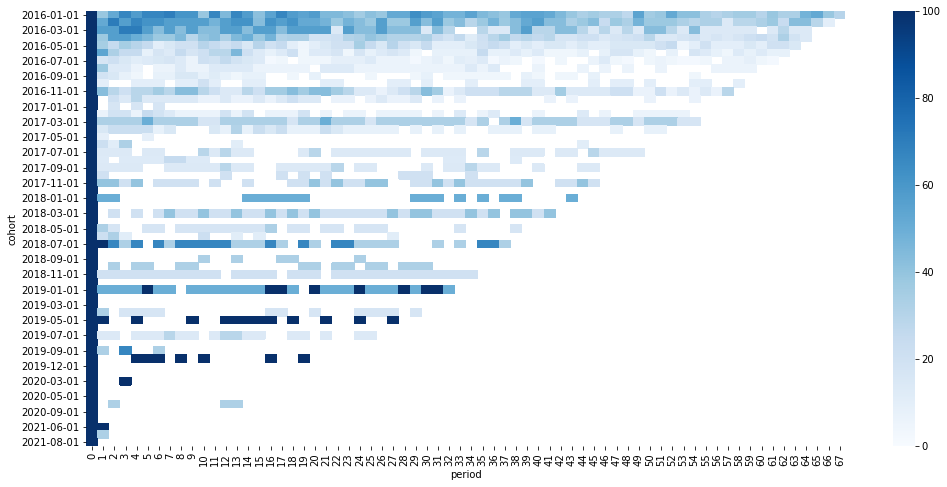

In [44]:
plt.figure(figsize=(17, 8))
sns.heatmap(pd.pivot_table(data=grp_cohorts, index='cohort', columns='period', values='cohort_pct'),
           cmap='Blues', vmin=0);

In [45]:
df_sales_full_customers.head() 

код_товара код_клиента               время  кол-во  себест.    цена  \
3       KB008       KL367 2016-03-31 11:45:36     2.0    36.00  45.800   
4       KB008       KL355 2016-03-31 10:58:05     1.0    36.00  46.950   
5       KB008       KL226 2016-03-31 11:46:59     1.0    36.00  46.560   
7       ZS084       KL203 2016-03-31 10:32:12     5.0     3.60   4.770   
14      TS015       KL311 2016-03-31 09:25:19     5.0     2.47   3.244   

                  код_заказа  сумма_продаж        дата год_месяц  \
3   KL3672016-03-31 11:45:36         91.60  2016-03-31    201603   
4   KL3552016-03-31 10:58:05         46.95  2016-03-31    201603   
5   KL2262016-03-31 11:46:59         46.56  2016-03-31    201603   
7   KL2032016-03-31 10:32:12         23.85  2016-03-31    201603   
14  KL3112016-03-31 09:25:19         16.22  2016-03-31    201603   

    курс_доллара  продажи_грн  
3          26.23         2402  
4          26.23         1231  
5          26.23         1221  
7          26.23          625  
14         26.23          425

In [46]:
# 23 365
students = 23
days = pd.Series(np.arange(366))
n_experiments = 10000

random_day = 64
count = 0

for i in range(n_experiments):
    count_birthdays = 0
    student_birthdays = days.sample(23, replace=True)
    if random_day in student_birthdays:
        for birthday in student_birthdays:
            if birthday == random_day:
                count_birthdays += 1
        if count_birthdays == 2:
            count += 1

print(count / )

SyntaxError: invalid syntax (<ipython-input-46-be7b9f12e19b>, line 19)